# Raneem Ibraheem ID: 212920896
# Aseel Nahhas ID: 212245096

# Code cell 1:
First we import the required libraries and check the GPU

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("Is CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 1.10.2+cu113
CUDA Version: 11.3
Is CUDA Available: True
GPU Name: GeForce GTX 1080
Using device: cuda


# Code cell 2:
In here we start by transforming the data to tensors and resizing the images and normalizing it to be able to work with it later.
Then we preprocess the data and split it into the training sets and the testing sets as we always do, and give each sample a class, also we split the training data to training and validation as well, then we use dataloaders to load the data in batches

In [3]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# map training data to classes
class WeatherDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        class_mapping = {'Cloudy': 0, 'Sunrise': 1, 'Shine': 2, 'Rain': 3}
        
        for class_name, label in class_mapping.items():
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for image_name in os.listdir(class_dir):
                    if image_name.lower().endswith('.jpg'):
                        image_path = os.path.join(class_dir, image_name)
                        self.data.append(image_path)
                        self.labels.append(label)
            else:
                print(f"Warning: Class directory '{class_dir}' is missing!")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# map test data to classes
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        class_mapping = {'cloudy': 0, 'sunrise': 1, 'shine': 2, 'rain': 3}

        for image_name in os.listdir(root_dir):
            if image_name.lower().endswith('.jpg'):
                for class_name, label in class_mapping.items():
                    if image_name.lower().startswith(class_name):
                        image_path = os.path.join(root_dir, image_name)
                        self.data.append(image_path)
                        self.labels.append(label)
                        break
                else:
                    raise ValueError(f"Unknown label in filename: {image_name}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# load datasets
train_dir = './'
test_dir = './Test'

# create datasets
train_dataset = WeatherDataset(train_dir, transform=transform)
test_dataset = TestDataset(test_dir, transform=transform)

# split training dataset into training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ['cloudy', 'sunrise', 'shine', 'rain']
print(f"Classes: {classes}")


Classes: ['cloudy', 'sunrise', 'shine', 'rain']


# Code cell 3:
import the pretrained model resnet 18 and then define the dropout layer and then call it

In [4]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
# change the output layer
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, len(classes))
)
model = model.to(device)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Code cell 4:
in here we define our custom loss function, ignore the name of the function (i liked the meme from the tutorial presentation)
this loss function used label smoothing, we ditributed the values between 0 and 1 for all the classes<br>
here is the formula:
$$
\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} \left[ -\tilde{y}_{i,c} \cdot \log(\text{Softmax}(z_{i,c})) \cdot w_c \right]
$$


In [5]:
# Loss function and optimizer
class AbrahamLossFunction(nn.Module):
    def __init__(self, smoothing=0.1, num_classes=4, weight=None):
        super(AbrahamLossFunction, self).__init__()
        self.smoothing = smoothing
        self.num_classes = num_classes
        self.weight = weight

    # forward pass of the loss function
    def forward(self, predictions, targets):
        assert targets.min() >= 0 and targets.max() < self.num_classes, \
            f"Targets should be in range [0, {self.num_classes - 1}], but found {targets}"

        # convert targets to one-hot encoding 
        targets_one_hot = torch.zeros_like(predictions).scatter_(1, targets.unsqueeze(1), 1)
        # smooth the one-hot encoding
        smooth_targets = (1 - self.smoothing) * targets_one_hot + self.smoothing / self.num_classes
        # calculate the loss
        loss = -smooth_targets * torch.log_softmax(predictions, dim=1)
        if self.weight is not None:
            loss *= self.weight[targets].unsqueeze(1)
        return loss.sum(dim=1).mean()

class_weights = torch.tensor([1.0, 1.5, 1.2, 1.3], device=device)
criterion = AbrahamLossFunction(smoothing=0.1, num_classes=len(classes), weight=class_weights)


# Code cell 5:
in here we just define the optimizer and the scheduler, we saw why the adam optimizer is good,  and the scheduler in this case adjusts the learning rate over the epochs to find the best learning rate

In [6]:
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=25)

# Code cell 6:
iin this code cell we train the model then evaluate it, we first scale the data and run over the data to start training the model, we apply the loss function, the optimizer and the scheduler and we store the results in lists, then we move to evaluating the model by testing it on unseen data, at the end of the run we also print the confusion matrix

Epoch 1/15, Train Loss: 1.7660, Val Loss: 1.0754, Train Acc: 0.4064, Val Acc: 0.8169
Epoch 2/15, Train Loss: 1.0400, Val Loss: 0.6694, Train Acc: 0.7479, Val Acc: 0.9296
Epoch 3/15, Train Loss: 0.7943, Val Loss: 0.5867, Train Acc: 0.8822, Val Acc: 0.9765
Epoch 4/15, Train Loss: 0.7223, Val Loss: 0.5931, Train Acc: 0.9258, Val Acc: 0.9531
Epoch 5/15, Train Loss: 0.6882, Val Loss: 0.5785, Train Acc: 0.9293, Val Acc: 0.9765
Epoch 6/15, Train Loss: 0.6970, Val Loss: 0.5577, Train Acc: 0.9376, Val Acc: 0.9812
Epoch 7/15, Train Loss: 0.6920, Val Loss: 0.5745, Train Acc: 0.9317, Val Acc: 0.9765
Epoch 8/15, Train Loss: 0.6553, Val Loss: 0.5447, Train Acc: 0.9446, Val Acc: 0.9859
Epoch 9/15, Train Loss: 0.6130, Val Loss: 0.5426, Train Acc: 0.9623, Val Acc: 0.9859
Epoch 10/15, Train Loss: 0.6578, Val Loss: 0.5334, Train Acc: 0.9588, Val Acc: 0.9859
Epoch 11/15, Train Loss: 0.6284, Val Loss: 0.5560, Train Acc: 0.9552, Val Acc: 0.9671
Epoch 12/15, Train Loss: 0.6107, Val Loss: 0.5362, Train Acc: 0

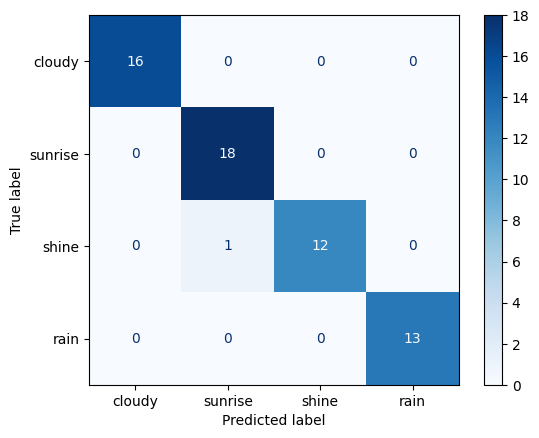

In [7]:
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

scaler = GradScaler()

# evaluate the model on the test set and return the accuracy and confusion matrix
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    return acc, cm

# train the model and return the training and validation losses and accuracies
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    test_accuracies = []

    # train the model for num_epochs epochs and evaluate it after each epoch
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        # iterate over the training data and update the weights using the optimizer and scheduler
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients and perform a forward pass
            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            # perform a backward pass, update the weights and keep track of the loss and accuracy
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    test_acc, test_cm = evaluate_model(model, test_loader)
    test_accuracies = [test_acc] * num_epochs
    print(f"\nFinal Test Accuracy: {test_acc * 100:.2f}%")
    ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=classes).plot(cmap="Blues")
    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies, test_accuracies

train_losses, val_losses, train_accuracies, val_accuracies, test_accuracies = train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=15
)


# Code cell 7:
in the following code cell we show the predictions of the model

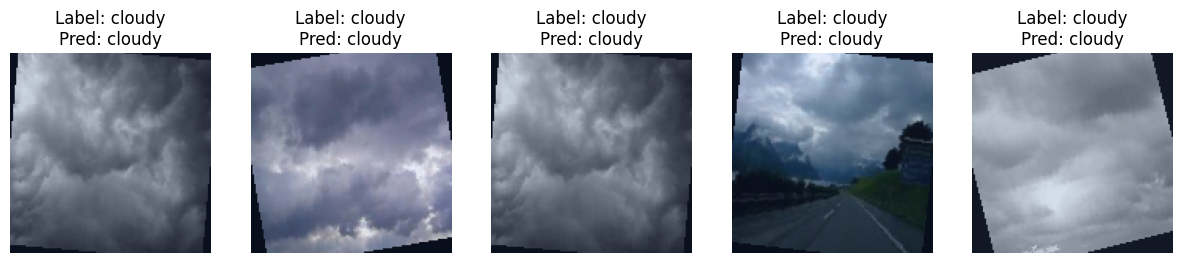

In [8]:
import random
# show predictions for a few images
def show_predictions(model, test_loader, classes, num_images=5):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        idx = random.randint(0, len(images) - 1)
        img = images[idx].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img * 0.229 + 0.485, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {classes[labels[idx]]}\nPred: {classes[preds[idx]]}")
        axes[i].axis("off")
    plt.show()

show_predictions(model, test_loader, classes, num_images=5)

# Code cell 8:
in this code cell we only plot the results

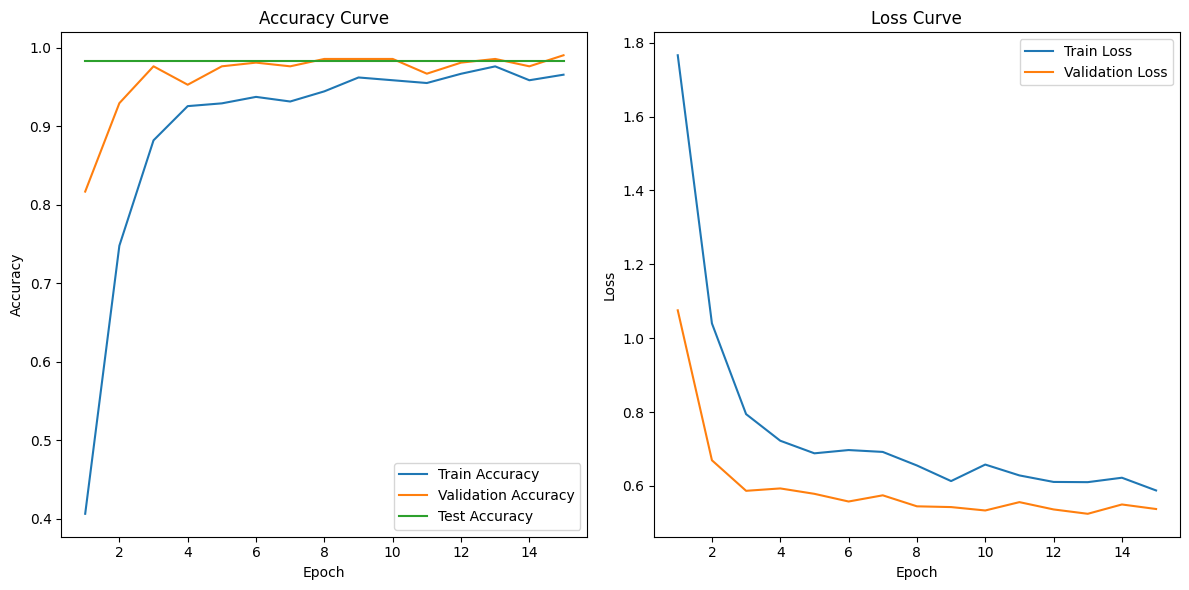

In [9]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.tight_layout()
plt.show()


# Code cell 9:
we only print the model information and the parameters count

In [10]:
from torchsummary import summary

# print the model's layer details and the total number of parameters
summary(model, input_size=(3, 128, 128), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,